In [3]:
# ONLY RUN THIS IF YOU PLAN ON USING GOOGLE COLAB
# PLACE EVERYTHING INSIDE /PROJECT AT THE ROOT OF YOUR GOOGLE DRIVE
# USING GOOGLE COLAB IS NOT MANDATORY.

from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/project')

Mounted at /content/drive


Code has been modified from and improved from INDIVIDUAL component by (z5209600)

In [4]:
### Car Detection Module - LinearSVM + HOG ##################
# 4/6/2021 - 23/4/2021
# 
# ZID           NAME
# z5109480      Andrew Simpson 
# z5122508      Dean Poulos
# z5207952      Tom Wright 
# z5209600      Daniel Pham
#
### IMPORTS #################################################

import cv2
import matplotlib.pyplot as plt 
import numpy as np
import json
import os
import glob
import pickle
import random
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM
from skimage.feature import local_binary_pattern

### BEFORE RUNNING PROGRAM  ##################################
#
# Please download and extract the zip files in both:
# 1. VELOCITY ESTIMATINATION CHALLENGE
# 2. LANE DETECTION CHALLENGE 
# From https://github.com/TuSimple/tusimple-benchmark/issues/3
# by Kivinju (on github) cited as [40] in report.
#
# Then extract the zip files, there now should be 5 folders 
# located at in the root of this folder:
# 1. data/train_set
# 2. data/test_set
# 3. data/benchmark_velocity_train
# 4. data/benchmark_velocity_test
# 5. data/benchmark_velocity_supp
#
################################################################

# Classifiers
linear_classifier = LinearSVC(max_iter=10000) # Better with larger dataset & has custom loss.
linear_classifier2 = SVC(gamma='auto', kernel="linear")
rbf_classifier = SVC(gamma='auto', class_weight="balanced", C=1 )
one_linear_classifier = OneClassSVM(gamma='auto', kernel="linear")
one_rbf_classifier = OneClassSVM(gamma='auto')

classifier = {
    "linear_classifier" : [linear_classifier, 2], 
    "linear_classifier2" : [linear_classifier2, 2],
    "rbf_classifier" : [rbf_classifier, 2],
    "one_linear_classfier" : [one_linear_classifier, 1],
    "one_rbf_classifier" : [one_rbf_classifier, 1],
}

feature_extraction = {
    "HOG": None,
}

colour_channel = {
    "RGB": cv2.COLOR_BGR2RGB,
    "HSV": cv2.COLOR_BGR2HSV,
    "YCrCb": cv2.COLOR_BGR2YCrCb,
    "LAB": cv2.COLOR_BGR2LAB,
    "GRAY": cv2.COLOR_BGR2GRAY
}

CLASSIFIER = "linear_classifier"

# PATHS
SUPP_PATH = "data/benchmark_velocity_supp/"
TEST_PATH = "data/benchmark_velocity_test/"
TRAIN_PATH = "data/benchmark_velocity_train/"
MODEL_PATH = "models/"
OUTPUT_PATH = "data/evaluation/"
# ENABLE CLASSIFIERS
ENABLE_HOG = True
ENABLE_HARRIS = False           # Only works on linear classifier
ENABLE_LBP = True               # Only works on linear classifier
ENABLE_HARALICK = False         # Only works on linear classifier

BGR_CONVERTER = cv2.COLOR_YCrCb2BGR # Convert back to BGR to convert to GRAYSCALE

# DEBUG
SAVE_INPUT = False             # Requires car/clip/result/bgnm to be in directory

# HYPERPARAMETERS
TRAINING_SIZE = 1000
SUPPLEMENTARY_SIZE = 5000
WINDOW_SIZE = (64,64)       
STRIDE = 8                     # Window stride - Change heatmap th for better classification
COLOUR_SPACE = "YCrCb"         # Colour Space - Influences HOG detection
SEED = 1337

#1. Helper Functions

In [5]:

# Resizes image to wsz
def resize_image(im,wsz, prevent_stretching=True):
    # Check if im is smaller than wsz and remove noisy imgs
    if im.shape[0]<=wsz[0]>>1 or im.shape[1]<=wsz[1]>>1: return
    if wsz[0]<=im.shape[0] or wsz[1]<=im.shape[1]:
        rsz_im = cv2.resize(im,wsz,cv2.INTER_AREA)
    elif prevent_stretching is not True:
        rsz_im = cv2.resize(im,wsz,cv2.INTER_CUBIC)
    else: return
    if rsz_im.shape[0] != wsz[0] or rsz_im.shape[1] != wsz[1]:
        print("errno. 2")
    else: return rsz_im

# Squares a coordinate region.
def square_region(region):
    (h0,w0),(h1,w1) = region
    h,w = h1-h0, w1-w0
    a = abs(h-w)>>1
    o = (h-w)%2
    if w<h:
        w0 -= a
        w1 += a+o
    else: 
        h0 -= a
        h1 += a+o
    return (h0,w0),(h1,w1)

# Clears images from debugger
def clear_images():
    print("CLEARING GENERATED FILES")
    cars = glob.glob("car/*")
    bg = glob.glob("bg/*")
    result = glob.glob("result/*")
    for f in cars: os.remove(f)
    for f in bg: os.remove(f)
    for f in result: os.remove(f)
        
#######################
#  FEATURE SELECTION  #
#######################

# Extracts Harris Corners from image
# Values taken from: opecv tutorial page (did not generate a good base for hypertuning)
def harris_corner(im):
    features = cv2.cornerHarris(im,2,3,0.04).reshape(1,-1)[0]
    return features

# Extracts local binary pattern
def lbp(im):
    features = local_binary_pattern(im,8,1,method='uniform')
    hist, _ = np.histogram(features.reshape(1,-1)[0],
                           bins = 11,
                           range = (0,10))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Defining GLCM
def GLCM(im):
    glcm = greycomatrix(im, distances=[1], angles=[0], levels=256,
           symmetric=True, normed=True)
    features = []
    features.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    features.append(greycoprops(glcm, 'correlation')[0, 0])
    features.append(greycoprops(glcm, 'homogeneity')[0, 0])
    features.append(greycoprops(glcm, 'contrast')[0, 0])
    features.append(greycoprops(glcm, 'energy')[0, 0])
    return features
    
# Extracts hog descriptors from image.
def HOG_feature(im):
    hog = feature_extraction["HOG"]
    if hog is None:
        winsz = WINDOW_SIZE
        blksz = (16,16)
        blkstrd = (8,8)
        cellsz = (8,8)
        bins = 9
        hog = cv2.HOGDescriptor(winsz,blksz,
              blkstrd,cellsz,bins, _gammaCorrection=True)

    features = hog.compute(im).reshape(1,-1)[0]
    return features

# Extras Features from an image and assigns labels.
def get_features(im, label=None, data=None):    
    # Normalise Image
    im = im.copy()
    cv2.normalize(im, im, 0, 255, cv2.NORM_MINMAX)
    
    # Convert to grayscale for Harris & LBP
    gray = cv2.cvtColor(im, BGR_CONVERTER)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    # Extract features
    fs = []
    if ENABLE_HOG:      fs.append(HOG_feature(im))
    if ENABLE_HARRIS:   fs.append(harris_corner(gray))
    if ENABLE_LBP:      fs.append(lbp(gray))
    if ENABLE_HARALICK: fs.append(GLCM(gray))
        
    # Put features together
    features = np.concatenate(fs, axis=None)

    # Assign label
    if data is None or label is None: return features
    tX, tY = data
    tX.append(features)
    tY.append(label)
    
    
#####################
#  IMAGE SAMPLING   #
#####################

# Sample Background using random sample method
def sample_background(im, bbs, ctr, data):
    wy,wx = WINDOW_SIZE[0], WINDOW_SIZE[1]
    attempts = 50
    bg_ims = []
    for i in range(attempts):
        t = random.randrange(im.shape[0] * 2//5, im.shape[0] - wy)
        l = random.randrange(im.shape[1] - wx)
        b, r = t + wx, l + wy
        bb0 = (t,l),(b,r)
        repeat = False
        for bb1 in bbs:
            if check_overlap(bb0, bb1): 
                repeat = True
                break
        if not repeat: break
            
    if bb0 is not None: bg_ims.append(im[t:b,l:r])


    # Save Images
    for idx, region in enumerate(bg_ims):
        if SAVE_INPUT: 
            im = cv2.cvtColor(region, BGR_CONVERTER)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            cv2.imwrite(f'bg/{ctr}-{idx}.jpg', im)
        get_features(region, 0, data)
    
# Gets image from MAIN dataset
def get_image(idx, colour_space=COLOUR_SPACE):
    im = cv2.imread(TRAIN_PATH + f"clips/{idx}/imgs/040.jpg")
    im = cv2.cvtColor(im, colour_channel[colour_space])
    return im

# Gets image from SUPPLEMENTARY dataset
def get_image_supplementary(idx, colour_space=COLOUR_SPACE):
    im = cv2.imread(SUPP_PATH + f"supp_img/{str(idx).zfill(4)}.jpg")
    im = cv2.cvtColor(im, colour_channel[colour_space])
    return im

# Gets image from TEST dataset
def get_image_test(idx, frame, colour_space=COLOUR_SPACE):
    im = cv2.imread(TEST_PATH + f"clips/{idx}/imgs/{str(frame).zfill(3)}.jpg")
    im = cv2.cvtColor(im, colour_channel[colour_space])
    return im

# Get boundary boxes of cars from MAIN dataset
def get_bbs(idx, rect = False):
    f = open(TRAIN_PATH + f"clips/{idx}/annotation.json")
    data = json.load(f)
    f.close()
    bbs = []
    for i in range(len(data)):
        c = list(data[i]["bbox"].values())
        if rect: bb = [(int(c[3]),int(c[0])) , (int(c[1]),int(c[2]))]
        else: bb = [(int(c[0]),int(c[3])) , (int(c[2]),int(c[1]))]
        bbs.append(bb)
    return bbs

# Get boudary boxes of cars from SUPPLEMENTARY dataset
def get_bbs_supplementary(idx, data):
    data = data[idx-1]["bbox"]
    bbs = []
    for i in range(len(data)):
        c = list(data[i].values())
        bb = [(int(c[0]),int(c[3])) , (int(c[2]),int(c[1]))]
        bbs.append(bb)
    return bbs
                   
# Sample Cars
def sample_cars(im, bbs, ctr, data, shrink_only=True):
    for idx, bb in enumerate(bbs):
        (h0,w0),(h1,w1) = square_region(bb)
        im_label = im[h0:h1,w0:w1]
        if im_label.shape[0] != im_label.shape[1]: continue
        rsz_im = resize_image(im_label, WINDOW_SIZE, shrink_only)
        if rsz_im is None: continue
        if SAVE_INPUT: cv2.imwrite(f'car/{ctr}-{idx}.jpg', rsz_im)
        get_features(rsz_im, 1, data)
                   
# Sample Cars and Background
def sample_images(data, use_supplementary=True):
    if SAVE_INPUT: clear_images()
    tsz = TRAINING_SIZE
    ssz = SUPPLEMENTARY_SIZE
    random.seed(SEED)
    
    # Sample cars using MAIN dataset
    for idx in range(1, tsz+1):
        if not idx % 100: 
            print(f"Main: {idx}/{tsz} ({idx/tsz*100:.2f}%)")
        im, bbs = get_image(idx), get_bbs(idx)
        sample_cars(im, bbs, idx, data, shrink_only=False)
        
    # Sample background and CARS using SUPP dataset
    fd = open(SUPP_PATH + "annotation.json")
    labels = json.load(fd)
    for idx in range(1, ssz+1):
        if not idx % 100: print(f"Supp: {idx}/{ssz} ({idx/ssz*100:.2f}%)")
        im, bbs = get_image_supplementary(idx), get_bbs_supplementary(idx, labels)
        if use_supplementary: sample_cars(im, bbs, -idx, data, shrink_only=True)
        sample_background(im, bbs, idx, data)
    fd.close()

# Save the classifier
def save_classifier(clf, name):
    if os.path.exists(MODEL_PATH) is False:
        os.makedirs(MODEL_PATH)
    f = open(MODEL_PATH + name, 'wb')
    pickle.dump(clf, f)
    f.close()

# Load the classifier
def load_classifier(name):
    f = open(MODEL_PATH + name, 'rb')
    clf = pickle.load(f)
    f.close()
    return clf

# Train ML classifier
def train_classifier(model, data):
    print(f"Classifier {model} is under training..")
    global classifier
    model, args = classifier[model]
    if args == 2:
        model = model.fit(data[0], data[1])
    elif args == 1: 
        model = model.fit(data[0])
    print("Model Completed")
    return model

# Classify Images
def classify_images(data, model):
    res = model.predict(data)
    res[res<1] = 0
    return res

# Classify Image
def classify_image(data, model):
    res = model.predict([data])[0]
    if res < 1: return 0
    return 1

# Get Heatmap using sliding Window
def get_heatmap(model, im, max_mag=-1, show_progress=True):
    if show_progress: print("Searching for cars..")
    if max_mag == -1: max_mag = 4
    wsz, mag = WINDOW_SIZE, 0
    heatmap = np.zeros(im.shape[:2])
    while im.shape[0]>=wsz[0] and im.shape[1]>=wsz[1]:
        for i in range(im.shape[0]*2//5, im.shape[0], STRIDE):
            if i+wsz[0]>im.shape[0]: break
            for j in range(0, im.shape[1], STRIDE):
                if j+wsz[1]>im.shape[1]: break
                bb = im[i:i+wsz[0], j:j+wsz[1]]
                features = get_features(bb)
                if classify_image(features, model):
                    c0 = j*(1<<mag),i*(1<<mag)
                    c1 = (j+wsz[1])*(1<<mag),(i+wsz[0])*(1<<mag)
                    color = (0,255,0)
                    heatmap[c0[1]:c1[1],c0[0]:c1[0]] += 1
                    #cv2.rectangle(o_im, c0, c1, color, 2)
                    cv2.imwrite(f"result/result_{i}_{j}.jpg", bb)
        mag += 1
        if show_progress: print(f"Progress: {mag}/{max_mag}")
        if mag==max_mag: break
        im = cv2.pyrDown(im)
    if show_progress: print(f"Search completed.")
    return heatmap            

# Applies threshold to a heatmap and using rectangle contours
def get_boundary(heatmap, threshold=30, im=None):
    u8 = heatmap.astype(np.uint8)
    _, thresh = cv2.threshold(u8, threshold, 255, 0)
    kernel = np.ones((5,5),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel,iterations = 10)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Contours
    bb = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        res = [(x,y),(x+w,y+h)]
        cv2.rectangle(im, res[0], res[1], (0,255,0), 8)
        bb.append(res)
    return thresh, bb

                         
# Finds all cars given an image
def find_cars(im, model, max_mag=-1, th=0, heatmap=None, show_progress=True):
    if heatmap is None: 
        map = cv2.cvtColor(im, colour_channel[COLOUR_SPACE])
        heatmap = get_heatmap(model, map, max_mag, show_progress)
    thresh, bb = get_boundary(heatmap, threshold=th, im=im)
    return bb, heatmap, thresh

# Check if two boundary boxes are overlapping
def check_overlap(bb1, bb2):
    if (bb1[0][0] < bb2[1][0] and bb2[0][0] < bb1[1][0]):
        if (bb1[0][1] < bb2[1][1] and bb2[0][1] < bb1[1][1]):
            return True
    return False

# Check if two boundary boxes are overlapping using dict format
def overlap(bb1, bb2):
    if bb1["right"] < bb2["left"] or bb1["left"] > bb2["right"]:
        if bb1["bottom"] < bb2["top"] or bb1["top"] > bb2["bottom"]:
            return False  
    return True


# Gets the area of a bounding box
def area(bb):
    x = bb['right']-bb['left']
    y = bb['bottom']-bb['top']
    return x*y

# Draw bounding boxes on an image
def draw_bbs(im, bbs, color=(0,255,0)):
    for bb in bbs:
        (t,l),(b,r) = bb
        cv2.rectangle(im, (l,t), (r,b), color, 2)

# Determine the performance of the classifier
def evaluate_car(classifier_type):
    fdvs = open(SUPP_PATH + "annotation.json")
    fvs = json.load(fdvs)
    average_precision = 0
    average_recall = 0
    for clip in range(5020, 5060+1):
        if clip == 5057: continue # Badly labelled
        tp = 0
        fp = 0
        fn = 0
        fd = open(OUTPUT_PATH + f"supp/{clip}_{classifier_type}.json")
        f = json.load(fd)
        bbs1 = f[str(clip)]
        fd.close()
        bbs2 = fvs[clip-1]["bbox"]
        l = 0
        for i in range(len(bbs1)):
            best_iou = 0
            for j in range(len(bbs2)):
                current_iou = IOU(bbs1[i-tp],bbs2[j])
                if current_iou > best_iou:
                    best_iou = current_iou
                    bbx = (i,j)
            if best_iou > 0.5:
                del bbs1[bbx[0]-tp]
                del bbs2[bbx[1]]
                tp += 1
        fp = len(bbs1)
        fn = len(bbs2)
        if tp+fp: precision = tp/(tp+fp)
        else: precision = 0
        if (tp+fn): recall = tp/(tp+fn)
        else: recall = 0
        print(f"{clip} | precision: {precision:.2f}, recall: {recall:.2f}")
        average_precision += precision/40
        average_recall += recall/40
    print(f"Average Precision: {average_precision:.2f}")
    print(f"Average Recall: {average_recall:.2f}")
    fdvs.close()

# Returns the IOU of two bounding boxes
def IOU(bb1, bb2):
    if overlap(bb1,bb2) is False: return 0
    
    # For X
    if bb2["left"] <= bb1["left"] <= bb2["right"]:
        if bb2["left"] <= bb1["right"] <= bb2["right"]:
            overlap_x = bb1["right"] - bb1["left"]  # bb1 inside bb2
        else: overlap_x = bb2["right"] - bb1["left"] # bb1 lhs overlap bb2
    elif bb2["left"] <= bb1["right"] <= bb2["right"]:
        overlap_x = bb1["right"] - bb2["left"]  # bb1 rhs overlap bb2
    else: overlap_x = bb2["right"] - bb2["left"] # bb2 inside bb1

    # For Y
    if bb2["top"] <= bb1["top"] <= bb2["bottom"]:
        if bb2["top"] <= bb1["bottom"] <= bb2["bottom"]:
            overlap_y = bb1["bottom"] - bb1["top"]  # bb1 inside bb2
        else: overlap_y = bb2["bottom"] - bb1["top"] # bb1 lhs overlap bb2
    elif bb2["top"] <= bb1["bottom"] <= bb2["bottom"]:
        overlap_y = bb1["bottom"] - bb2["top"]  # bb1 rhs overlap bb2
    else: overlap_y = bb2["bottom"] - bb2["top"] # bb2 inside bb1

    #print (f"{bb1} {bb2}")
    AND = overlap_y*overlap_x
    OR = area(bb1)+area(bb2)-2*AND
    #print(f"{AND} {OR}")
    return AND/OR

# NEW SAMPLING TECHNIQUE
def hard_negative_mine(im, bbs, data, model, ctr, max_mag=-1):
    tX , tY = data
    if max_mag == -1: max_mag = 4
    wsz, mag = WINDOW_SIZE, 0
    heatmap = np.zeros(im.shape[:2])
    while im.shape[0]>=wsz[0] and im.shape[1]>=wsz[1]:
        for i in range(im.shape[0]*2//5, im.shape[0], wsz[0]):
            if i+wsz[0]>im.shape[0]: break
            for j in range(0, im.shape[1], wsz[1]):
                if j+wsz[1]>im.shape[1]: break
                bb = im[i:i+wsz[0], j:j+wsz[1]]
                features = get_features(bb)
                if classify_image(features, model):
                    bb0 = (i,j),(i+wsz[0],j+wsz[1])
                    is_correct = False
                    for bb1 in bbs:
                        bb1 = (bb1[0][0]>>mag,bb1[0][1]>>mag),(bb1[1][0]>>mag,bb1[1][1]>>mag)
                        if check_overlap(bb0, bb1): 
                            is_correct = True
                            break
                    if is_correct is not True:
                        tX.append(features)
                        tY.append(0)
                        if SAVE_INPUT: 
                            bb = cv2.cvtColor(im[i:i+wsz[0], j:j+wsz[1]], BGR_CONVERTER)
                            bb = cv2.cvtColor(bb, cv2.COLOR_BGR2RGB)
                            cv2.imwrite(f'bgnm/{ctr}-{mag}-{i}-{j}.jpg', bb)
        mag += 1
        if mag==max_mag: break
        im = cv2.pyrDown(im)
    

#2. Training Classifier w/ Random Sampling

##2.1. Training the Data

In [ ]:
# Train Classifier
data = [],[]
sample_images(data, use_supplementary=True)
clf = train_classifier(CLASSIFIER, data)

# Save
save_classifier(clf, "model.dat")

Main: 100/1000 (10.00%)
Main: 200/1000 (20.00%)
Main: 300/1000 (30.00%)
Main: 400/1000 (40.00%)
Main: 500/1000 (50.00%)
Main: 600/1000 (60.00%)
Main: 700/1000 (70.00%)
Main: 800/1000 (80.00%)
Main: 900/1000 (90.00%)
Main: 1000/1000 (100.00%)
Supp: 100/5000 (2.00%)
Supp: 200/5000 (4.00%)
Supp: 300/5000 (6.00%)
Supp: 400/5000 (8.00%)
Supp: 500/5000 (10.00%)
Supp: 600/5000 (12.00%)
Supp: 700/5000 (14.00%)
Supp: 800/5000 (16.00%)
Supp: 900/5000 (18.00%)
Supp: 1000/5000 (20.00%)
Supp: 1100/5000 (22.00%)
Supp: 1200/5000 (24.00%)
Supp: 1300/5000 (26.00%)
Supp: 1400/5000 (28.00%)
Supp: 1500/5000 (30.00%)
Supp: 1600/5000 (32.00%)
Supp: 1700/5000 (34.00%)
Supp: 1800/5000 (36.00%)
Supp: 1900/5000 (38.00%)
Supp: 2000/5000 (40.00%)
Supp: 2100/5000 (42.00%)
Supp: 2200/5000 (44.00%)
Supp: 2300/5000 (46.00%)
Supp: 2400/5000 (48.00%)
Supp: 2500/5000 (50.00%)
Supp: 2600/5000 (52.00%)
Supp: 2700/5000 (54.00%)
Supp: 2800/5000 (56.00%)
Supp: 2900/5000 (58.00%)
Supp: 3000/5000 (60.00%)
Supp: 3100/5000 (62.0

In [ ]:
dataset = {
    'features': data[0],
    'label': data[1]
}
save_classifier(dataset, "data.dat")

##2.2. Testing the model 
### 2.2.1. Generating Heatmap via sliding window

Searching for cars..
Progress: 1/4
Progress: 2/4
Progress: 3/4
Progress: 4/4
Search completed.


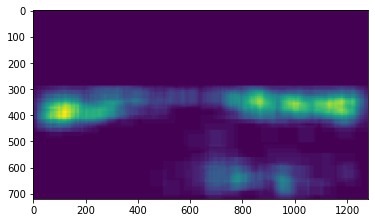

In [ ]:
###
image_ref = 1
clf = load_classifier("model.dat")
###

im = get_image(image_ref, colour_space="RGB")
bb, mapx, _ = find_cars(im.copy(), clf)
plt.imshow(mapx)

###2.2.2 Thresholding heatmap to obtain bounding boxes

[[(64, 352), (160, 416)], [(976, 344), (1024, 376)], [(1120, 336), (1192, 392)], [(848, 336), (880, 368)]]


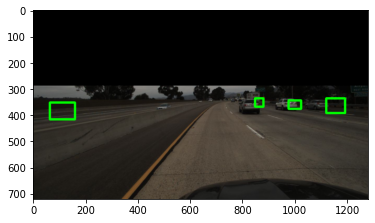

In [ ]:
im_copy = im.copy()
bb, mapx, thresh = find_cars(im_copy, clf, heatmap=mapx, th=48)
print(bb)
im_copy[0:im_copy.shape[0]*2//5] = 0 # cuts the top half (shows what the sliding window sees)
plt.imshow(im_copy)

### 2.2.3. Display of threshold of heatmap

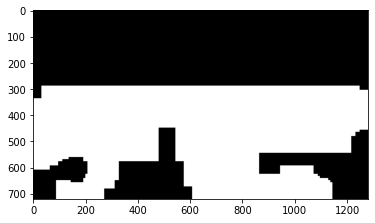

In [ ]:
plt.imshow(thresh, "gray")

#3. Negative Mining sampling technique

##3.1. Displaying Expected output.

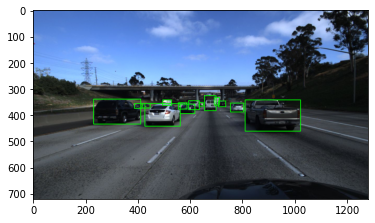

In [ ]:
fd = open(SUPP_PATH + "annotation.json")
labels = json.load(fd)
ima = get_image_supplementary(3, "RGB")
im_bb = ima.copy()
bb = get_bbs_supplementary(3,labels)
draw_bbs(im_bb, bb)
fd.close()
plt.imshow(im_bb)

## 3.2 Train the dataset w/ hard negative examples
On top of random sampling, for each sliding window which was a false positive, add that to the training sample and retrain.

In [ ]:
for i in range(1,SUPPLEMENTARY_SIZE+1):
    im = get_image_supplementary(i)
    bbs = get_bbs_supplementary(i,labels)
    hard_negative_mine(im,bbs,data,clf,i)
    if not i % 10: 
        print(f"retraining: {i}/{SUPPLEMENTARY_SIZE} ({i/SUPPLEMENTARY_SIZE*100:.2f}%)")

retraining: 10/5000 (0.20%)
retraining: 20/5000 (0.40%)
retraining: 30/5000 (0.60%)
retraining: 40/5000 (0.80%)
retraining: 50/5000 (1.00%)
retraining: 60/5000 (1.20%)
retraining: 70/5000 (1.40%)
retraining: 80/5000 (1.60%)
retraining: 90/5000 (1.80%)
retraining: 100/5000 (2.00%)
retraining: 110/5000 (2.20%)
retraining: 120/5000 (2.40%)
retraining: 130/5000 (2.60%)
retraining: 140/5000 (2.80%)
retraining: 150/5000 (3.00%)
retraining: 160/5000 (3.20%)
retraining: 170/5000 (3.40%)
retraining: 180/5000 (3.60%)
retraining: 190/5000 (3.80%)
retraining: 200/5000 (4.00%)
retraining: 210/5000 (4.20%)
retraining: 220/5000 (4.40%)
retraining: 230/5000 (4.60%)
retraining: 240/5000 (4.80%)
retraining: 250/5000 (5.00%)
retraining: 260/5000 (5.20%)
retraining: 270/5000 (5.40%)
retraining: 280/5000 (5.60%)
retraining: 290/5000 (5.80%)
retraining: 300/5000 (6.00%)
retraining: 310/5000 (6.20%)
retraining: 320/5000 (6.40%)
retraining: 330/5000 (6.60%)
retraining: 340/5000 (6.80%)
retraining: 350/5000 (7

In [ ]:
dataset = {
    'features': data[0],
    'label': data[1]
}
save_classifier(dataset, "rdata.dat")

In [ ]:
r_data = load_classifier("rdata.dat")
r_data = list(r_data.values())
clf_retrained = train_classifier(CLASSIFIER, r_data)
save_classifier(clf_retrained, "model_retrained.dat")

Classifier linear_classifier is under training..
Model Completed


In [ ]:
clf_retrained = load_classifier("model_retrained.dat")

#3.2.1. Display Comparison from heard negative mining
Note running the two code blocks below before training will show the classifier before negative mining has occurred. Rerun the two blocks to see updated image when dataset is retrained with hard negative mining

Searching for cars..
Progress: 1/4
Progress: 2/4
Progress: 3/4
Progress: 4/4
Search completed.


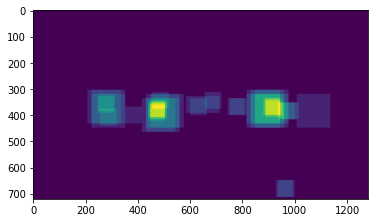

In [ ]:
bb, mapx, _ = find_cars(ima.copy(), clf_retrained)
plt.imshow(mapx)

[[(656, 336), (664, 376)], [(432, 320), (560, 448)], [(224, 320), (336, 432)], [(832, 304), (1000, 448)]]


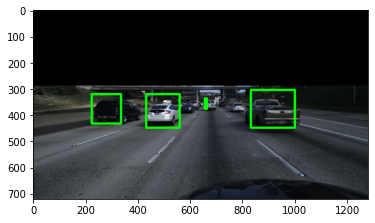

In [ ]:
th = 0
im_copy = ima.copy()
bb, mapx, thresh = find_cars(im_copy, clf_retrained, heatmap=mapx, th=2)
print(bb)
im_copy[0:im_copy.shape[0]*2//5] = 0 # cuts the top half (shows what the sliding window sees)
plt.imshow(im_copy)

In [ ]:
#clear_images() # Comment this out and enable SAVE_INPUT flag to see input images

## 3.3 - Testing images on TEST datset
we were using the supplementary dataset.
DISTANCE/VELOCITY component of the assignment uses the TEST dataset.

Searching for cars..
Progress: 1/4
Progress: 2/4
Progress: 3/4
Progress: 4/4
Search completed.


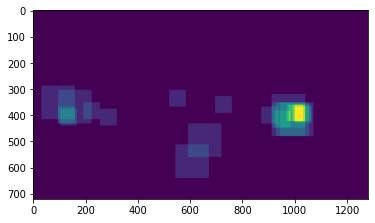

In [ ]:
### TESTING CLASSIFIER ###
im = get_image_test(3,1, "RGB")
bb, mapx, _ = find_cars(im.copy(), clf_retrained)
plt.imshow(mapx)

[[(104, 376), (160, 416)], [(920, 352), (1056, 448)]]


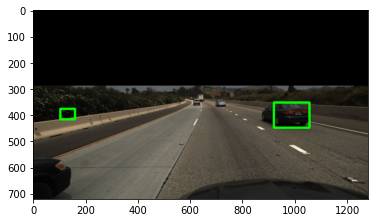

In [ ]:
im_copy = im.copy()
bb, mapx, thresh = find_cars(im_copy, clf_retrained, heatmap=mapx, th=3)
print(bb)
im_copy[0:im_copy.shape[0]*2//5] = 0 # cuts the top half (shows what the sliding window sees)
plt.imshow(im_copy)

# 4. Labelling a test clip for distance/velocity component

In [ ]:
### STORING AS A CLIP
CLIP_NO = 1
bb_json = {}
print("Scanning for cars...")
for i in range(1,41):
    im = get_image_test(CLIP_NO,i, "RGB")
    bbs, mapx, _ = find_cars(im, clf_retrained, th=3, show_progress=False)
    print(bbs)
    json_bbs = []
    for bb in bbs:
        car_bb = {
            "left": bb[0][0],
            "top": bb[0][1],
            "right": bb[1][0],
            "bottom": bb[1][1]
        }
        json_bbs.append(car_bb)
    bb_json[str(i)] = json_bbs
    print(f"Completed frame {i}/40 ({i/40:.2f})")
print("Scan Complete!")
json_format = json.dumps(bb_json)
f = open(OUTPUT_PATH + f"test/{str(CLIP_NO)}_HOG.json", "w")
f.write(json_format)
f.close()

# 5. Evaluating Random Sampling and Negative Mining Approach

In [ ]:
if os.path.exists(OUTPUT_PATH + "supp/") is False:
    os.makedirs(OUTPUT_PATH + "supp/")

# 5. Evaluating 
clfs = [clf, clf_retrained]
name = ["HOG", "HOG_RETRAINED"]
th = [48, 3]
bb_json = {}
for i in range(len(clfs)):
    for clip in range(5020, 5060+1):
        if clip == 5057: continue # Badly labelled
        im = get_image_supplementary(clip, "RGB")
        bbs, mapx, _ = find_cars(im, clfs[i], th=th[i], show_progress=False)
        json_bbs = []
        for bb in bbs:
            car_bb = {
                "left": bb[0][0],
                "top": bb[0][1],
                "right": bb[1][0],
                "bottom": bb[1][1]
            }
            json_bbs.append(car_bb)
        bb_json[str(clip)] = json_bbs
        json_format = json.dumps(bb_json)
        f = open(OUTPUT_PATH + f"supp/{str(clip)}_{name[i]}.json", "w")
        f.write(json_format)
        f.close()

In [ ]:
evaluate_car("HOG")

5020 | precision: 0.50, recall: 0.50
5021 | precision: 1.00, recall: 0.08
5022 | precision: 0.00, recall: 0.00
5023 | precision: 0.00, recall: 0.00
5024 | precision: 0.40, recall: 0.67
5025 | precision: 0.00, recall: 0.00
5026 | precision: 0.75, recall: 0.43
5027 | precision: 0.50, recall: 0.33
5028 | precision: 0.20, recall: 0.33
5029 | precision: 0.67, recall: 0.18
5030 | precision: 0.00, recall: 0.00
5031 | precision: 0.00, recall: 0.00
5032 | precision: 0.25, recall: 0.50
5033 | precision: 0.00, recall: 0.00
5034 | precision: 0.71, recall: 0.42
5035 | precision: 0.00, recall: 0.00
5036 | precision: 0.25, recall: 0.17
5037 | precision: 0.00, recall: 0.00
5038 | precision: 0.00, recall: 0.00
5039 | precision: 0.00, recall: 0.00
5040 | precision: 0.00, recall: 0.00
5041 | precision: 0.75, recall: 0.38
5042 | precision: 0.00, recall: 0.00
5043 | precision: 0.00, recall: 0.00
5044 | precision: 0.50, recall: 0.40
5045 | precision: 0.00, recall: 0.00
5046 | precision: 0.00, recall: 0.00
5

In [ ]:
evaluate_car("HOG_RETRAINED")

5020 | precision: 1.00, recall: 0.50
5021 | precision: 1.00, recall: 0.15
5022 | precision: 1.00, recall: 0.20
5023 | precision: 0.00, recall: 0.00
5024 | precision: 0.67, recall: 0.67
5025 | precision: 0.00, recall: 0.00
5026 | precision: 0.00, recall: 0.00
5027 | precision: 0.00, recall: 0.00
5028 | precision: 0.00, recall: 0.00
5029 | precision: 0.75, recall: 0.27
5030 | precision: 0.00, recall: 0.00
5031 | precision: 0.00, recall: 0.00
5032 | precision: 1.00, recall: 0.50
5033 | precision: 0.00, recall: 0.00
5034 | precision: 0.33, recall: 0.08
5035 | precision: 1.00, recall: 0.14
5036 | precision: 1.00, recall: 0.33
5037 | precision: 0.00, recall: 0.00
5038 | precision: 0.00, recall: 0.00
5039 | precision: 1.00, recall: 0.14
5040 | precision: 1.00, recall: 0.50
5041 | precision: 0.67, recall: 0.25
5042 | precision: 0.00, recall: 0.00
5043 | precision: 0.00, recall: 0.00
5044 | precision: 1.00, recall: 0.20
5045 | precision: 1.00, recall: 0.20
5046 | precision: 1.00, recall: 0.25
5

#6. Report Graphs

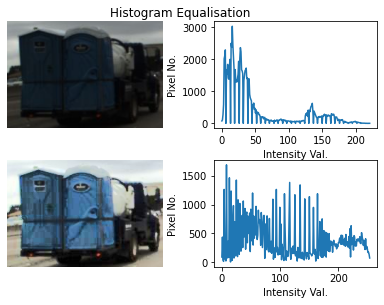

In [41]:
# Normalised Resolution
fig, ax = plt.subplots(2,2)
fd = open(SUPP_PATH + "annotation.json")
labels = json.load(fd)
(y1,x1),(y2,x2) = get_bbs_supplementary(2, labels)[0]
im1 = get_image_supplementary(2, "HSV")[y1:y2,x1:x2]
im2 = im1.copy()
im2[:,:,2] = cv2.equalizeHist(im2[:,:,2])
im1 = cv2.cvtColor(im1, cv2.COLOR_HSV2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_HSV2RGB)
hist1, bin_edges1 = np.histogram(im1, bins=256)
hist2, bin_edges2 = np.histogram(im2, bins=256)

fig.suptitle("Histogram Equalisation", y=1.0)
plt.tight_layout()
ax[0,0].imshow(im1)
ax[1,0].imshow(im2)
ax[0,1].plot(bin_edges1[0:-1], hist1)
ax[1,1].plot(bin_edges2[0:-1], hist2)
ax[0,0].axis('off')
ax[1,0].axis('off')
ax[0,1].set_ylabel('Pixel No.')
ax[0,1].set_xlabel('Intensity Val.')
ax[1,1].set_ylabel('Pixel No.')
ax[1,1].set_xlabel('Intensity Val.')
fd.close()

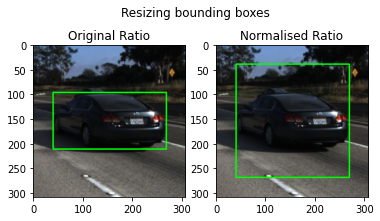

In [28]:
(y1,x1),(y2,x2) = get_bbs_supplementary(15, labels)[0]
reg = (y1,x1),(y2,x2)
im1 = get_image_supplementary(15, "RGB")
im2 = im1.copy()
draw_bbs(im1,[[(y1,x1),(y2,x2)]])
(y1,x1),(y2,x2) = square_region(reg) 
draw_bbs(im2, [[(y1,x1),(y2,x2)]])
fig, ax = plt.subplots(1,2)
fig.suptitle("Resizing bounding boxes", y=0.9)
ax[0].imshow(im1[y1-40:y2+40,x1-40:x2+40])
ax[0].set_title("Original Ratio")
ax[1].set_title("Normalised Ratio")
ax[1].imshow(im2[y1-40:y2+40,x1-40:x2+40])
#for i in range(len(ax)):
#    ax[i].axis('off')

802 333 867 377
(64, 64, 3)
(64, 64, 3)


Text(0.5, 1.0, 'Hog Image')

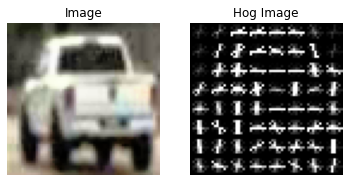

In [43]:
from skimage.feature import hog
from skimage import data, exposure
(x1,y1),(x2,y2) = get_bbs(2, labels)[0]
im1 = get_image(2, "YCrCb")[y1:y2,x1:x2]
im1 = resize_image(im1,(64,64), False)
o_im1 = im1.copy()
cv2.normalize(im1, im1, 0, 255, cv2.NORM_MINMAX)
print(f"{x1} {y1} {x2} {y2}")
print(im1.shape)
_, hog_im = hog(im1, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
hog_im = exposure.rescale_intensity(hog_im, in_range=(0,10))
o_im1 = cv2.cvtColor(o_im1, cv2.COLOR_YCrCb2BGR)
o_im1 = cv2.cvtColor(o_im1, cv2.COLOR_BGR2HSV)
o_im1[:,:,2] = cv2.equalizeHist(o_im1[:,:,2])
o_im1 = cv2.cvtColor(o_im1, cv2.COLOR_HSV2RGB)
print(im1.shape)
fig, ax = plt.subplots(1,2)
for i in range(len(ax)):
    ax[i].axis('off')
ax[0].imshow(o_im1)
ax[0].set_title('Image')
ax[1].imshow(hog_im, cmap="gray")
ax[1].set_title('Hog Image')
#fig.suptitle("Hog Descriptors", y=0.85)